In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("../mammografie.csv")

Aggiunta Feature

In [7]:
df = df.dropna(subset=['Severity', 'X', 'Y', 'Radius'])
df['Target'] = df['Severity'].map({'B': 0, 'M': 1})
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df = df.dropna(subset=['X', 'Y'])

df['Area'] = np.pi * (df['Radius'] ** 2)
df['DistanzaCentro'] = np.sqrt((df['X'] - 512)**2 + (df['Y'] - 512)**2)
df['RadiusBin'] = pd.qcut(df['Radius'], q=5, labels=['XS', 'S', 'M', 'L', 'XL'])

def quadrante(row):
    if row['X'] < 512 and row['Y'] < 512:
        return 'Q0'
    elif row['X'] >= 512 and row['Y'] < 512:
        return 'Q1'
    elif row['X'] < 512 and row['Y'] >= 512:
        return 'Q2'
    else:
        return 'Q3'
df['Quadrante'] = df.apply(quadrante, axis=1)

X = df[['Tissue', 'Class', 'Area', 'DistanzaCentro', 'Quadrante', 'RadiusBin']]
y = df['Target']

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

numeric_features = ['Area', 'DistanzaCentro']
categorical_features = ['Tissue', 'Class', 'Quadrante', 'RadiusBin']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


models = {
    'SVC': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
}

In [9]:

#Pipeline per ciascun modello
pipelines = {name: Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
]) for name, model in models.items()}

# VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('svc', pipelines['SVC']),
    ('rf', pipelines['RandomForest']),
    ('lr', pipelines['LogisticRegression']),
], voting='soft')

pipelines['VotingClassifier'] = voting_clf

Addestramento e valutazione

In [ ]:

results = []

for name, pipe in pipelines.items():
    print(f"\n🔍 ===== {name} =====")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno'], output_dict=True)
    print("🎯 Accuracy:", acc)
    print("📊 Confusion Matrix:\n", conf)
    print("📋 Classification Report:\n", classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno']))

    scores = cross_val_score(pipe, X, y, cv=10, scoring='accuracy')
    print(f"📈 Cross-validated Accuracy (10-fold): {scores.mean():.3f} ± {scores.std():.3f}")

    results.append({
        'Model': name,
        'Accuracy_Test': acc,
        'Recall_Maligno': report['Maligno']['recall'],
        'Precision_Benigno': report['Benigno']['precision'],
        'CrossVal_Mean': scores.mean(),
        'CrossVal_Std': scores.std()
    })

results_df = pd.DataFrame(results)
print("\n📊 Tabella comparativa modelli:")
print(results_df)

Barplot comparativo accuracies


🔍 ===== SVC =====
🎯 Accuracy: 0.75
📊 Confusion Matrix:
 [[10  4]
 [ 2  8]]
📋 Classification Report:
               precision    recall  f1-score   support

     Benigno       0.83      0.71      0.77        14
     Maligno       0.67      0.80      0.73        10

    accuracy                           0.75        24
   macro avg       0.75      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24

📈 Cross-validated Accuracy (10-fold): 0.545 ± 0.138

🔍 ===== RandomForest =====
🎯 Accuracy: 0.6666666666666666
📊 Confusion Matrix:
 [[8 6]
 [2 8]]
📋 Classification Report:
               precision    recall  f1-score   support

     Benigno       0.80      0.57      0.67        14
     Maligno       0.57      0.80      0.67        10

    accuracy                           0.67        24
   macro avg       0.69      0.69      0.67        24
weighted avg       0.70      0.67      0.67        24

📈 Cross-validated Accuracy (10-fold): 0.521 ± 0.097

🔍 ===== LogisticRe

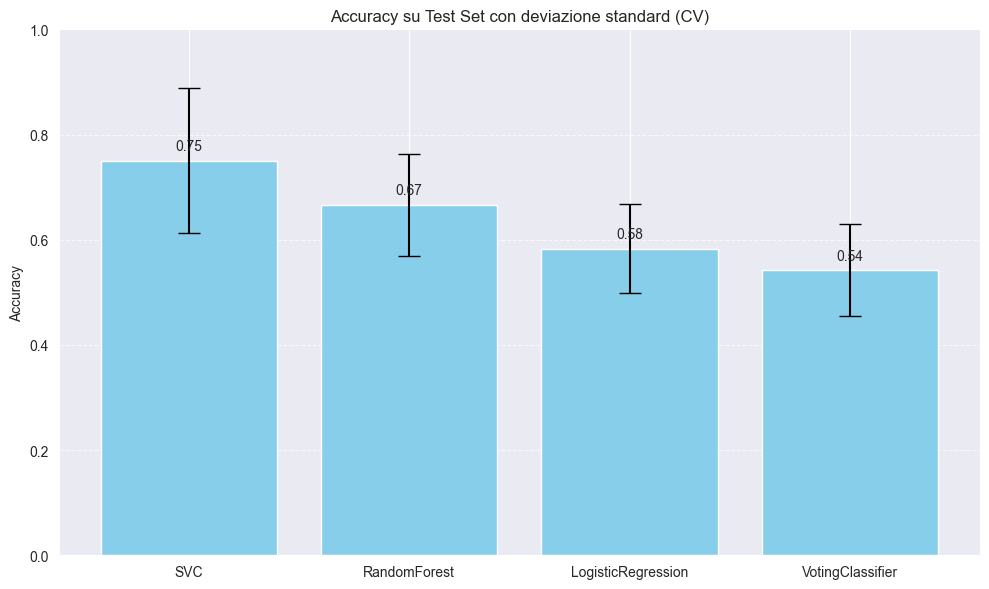

In [10]:

plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy_Test'],
               yerr=results_df['CrossVal_Std'], capsize=8, color='skyblue')

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy su Test Set con deviazione standard (CV)')
for bar, acc in zip(bars, results_df['Accuracy_Test']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{acc:.2f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()